# Winston Graves Project

In [1]:
pip install cfbd

  Obtaining dependency information for cfbd from https://files.pythonhosted.org/packages/0d/40/9fc01162f087b374b24a24e48a2a30626c69166e19f0eb69f9fcbbf73860/cfbd-4.5.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.8/358.8 kB 1.1 MB/s eta 0:00:00a 0:00:01m
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install beautifulsoup4

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Project:
    - Are highschool ratings accurate/helpful predictors of college success / being drafted? (247, espn, or rivals)
    - Accuracy will be measured using Highschool player ranks to predict draft status

In [4]:
import requests
import pandas as pd
import numpy as np
import re
import math
import os
import seaborn as sns

In [4]:
import cfbd
from bs4 import BeautifulSoup

**Define necessary scraping functions**

In [122]:
def create_df(start_yr, end_yr, players_per_yr):
    year = []
    for i in range(start_yr, end_yr+1):
        year = np.hstack([year, np.repeat(int(i), players_per_yr)])
    nrows = players_per_yr*len(range(start_yr, end_yr))
    years = pd.Series(year, name='Year')
    name = pd.Series(np.repeat('j', nrows), name='Player')
    pos = pd.Series(np.repeat('K', nrows), name='Position')
    ht = pd.Series(np.repeat('h', nrows), name='Height')
    wt = pd.Series(np.repeat('w', nrows), name='Weight')
    on3 = pd.Series(np.repeat('1', nrows), name='on3_Star')
    on3R = pd.Series(np.repeat('1', nrows), name='on3_Rating')
    two47 = pd.Series(np.repeat('1', nrows), name='247_Star')
    two47R = pd.Series(np.repeat('1', nrows), name='247_Rating')
    espn = pd.Series(np.repeat('1', nrows), name='ESPN_Star')
    espnR = pd.Series(np.repeat('1', nrows), name='ESPN_Rating')
    rival = pd.Series(np.repeat('1', nrows), name='Rivals_Star')
    rivalR = pd.Series(np.repeat('1', nrows), name='Rivals_Rating')

    df = pd.concat([years, name, pos, ht, wt, on3, on3R, two47, two47R, espn, espnR, rival, rivalR], axis=1)
    return(df)

In [169]:
def get_position(string):
    try:
        return(re.match(pattern='[A-z]+', string=string)[0])
    except:
        return(np.nan)

In [11]:
def get_text(html_soup):
    out = np.repeat('longtextdescription', len(html_soup))
    for i in range(len(html_soup)):
        out[i] = html_soup[i].text
    return(out)

In [12]:
def get_stars(html_soup):
    stars2=np.repeat('f', len(html_soup))
    for i in range(len(html_soup)):
        stars2[i] = html_soup[i]['aria-label']
    return(stars2)

In [41]:
def check_none(soup, class_type, tag='span'):
    return(soup.find(tag, class_=class_type)==None)

In [99]:
def get_ratings(soup):
    # find all divs with player star and rating info
    # x is 4 rating tags for each player on this page
    x = soup.find_all('div', class_='IndustryComparisonFourServicesItem_serviceItemWrapper__9AHiZ')
    subset_rating=np.repeat('fff', len(x))
    for i in range(len(x)):
        # if rating is none
        if check_none(x[i],'StarRating_overallRating__wz9dE StarRating_gray__LXyyB StarRating_small__jYqhq'):
            subset_rating[i] = np.nan
        else:
            subset_rating[i] = x[i].find('span', 
                                class_='StarRating_overallRating__wz9dE StarRating_gray__LXyyB StarRating_small__jYqhq').text
    return(subset_rating)

In [170]:
def scrape_on3_data(start_yr, end_yr, players_per_yr):
    if players_per_yr%50 != 0:
        return("Players per year must be a multiple of 50")
    # create data frame to store scraped data
    df = create_df(start_yr, end_yr, players_per_yr)
    # read in html data from on3.com 
    url_base = 'https://on3.com/db/rankings/industry-comparison/football/'
    ratings = []
    for yr in range(start_yr, end_yr+1): 
        html_players = []
        html_p_ht_wt = []
        html_ht = []
        html_wt = []
        html_stars = []
        html_ratings = []
        for pg in range(1, int(players_per_yr/50)+1): # 50 players per page
            page = requests.get(url_base+str(yr)+'/?page='+str(pg))
            soup = BeautifulSoup(page.content, "html.parser")
            html_players = html_players + soup.find_all('a', 
                         class_='MuiTypography-root MuiTypography-h5 MuiLink-root MuiLink-underlineNone css-1awuaxm')
            html_p_ht_wt = html_p_ht_wt + soup.find_all('p', 
                         class_='MuiTypography-root MuiTypography-body1 IndustryComparisonPlayerItem_vitalsContainer__4PF2i css-z52hnt')
            html_ht = html_ht + soup.find_all('span', 
                         class_='IndustryComparisonPlayerItem_height__6MMx_')
            html_wt = html_wt + soup.find_all('span', 
                         class_='IndustryComparisonPlayerItem_weight__L20kP')
            html_stars = html_stars + soup.find_all('span', 
                         class_='MuiRating-root MuiRating-sizeSmall Mui-readOnly StarRating_star__GR_Ff StarRating_small__jYqhq MuiRating-readOnly css-1a2asoj')
            ratings = np.append(ratings, get_ratings(soup))


        # for all players of a given year below
        names = get_text(html_players) 
        pos = pd.Series(get_text(html_p_ht_wt)).apply(get_position)
        ht = get_text(html_ht)
        wt = get_text(html_wt)
        stars = pd.Series(get_stars(html_stars))

        # use np.array() on pandas objects to remove index mismatch conflict
        df.loc[(df['Year']==yr), 'Player'] = names
        df.loc[(df['Year']==yr), 'Position'] = np.array(pos)
        df.loc[(df['Year']==yr), 'Height'] = ht
        df.loc[(df['Year']==yr), 'Weight'] = wt
        df.loc[(df['Year']==yr), 'on3_Star'] = np.array(stars[stars.index%5==1]) # on3 star rating is pos-1 out of 0:4 for all len 5 chunks
        df.loc[(df['Year']==yr), '247_Star'] = np.array(stars[stars.index%5==2]) # 247 star rating is pos-2 out of 0:4 for all len 5 chunks
        df.loc[(df['Year']==yr), 'ESPN_Star'] = np.array(stars[stars.index%5==3]) # ESPN star rating is pos-3 out of 0:4 for all len 5 chunks
        df.loc[(df['Year']==yr), 'Rivals_Star'] = np.array(stars[stars.index%5==4]) # Rivals star rating is pos-4 out of 0:4 for all len 5 chunks

    # rates will not be applied year by year, so they are done down here (outside the loop)
    # ratings in html are pulled in len 4 chunks, using remainder to bust up
    rates = pd.Series(ratings)
    df['on3_Rating'] = np.array(rates[rates.index%4==0]) # on3 ratings = 1st position in chunk of 4
    df['247_Rating'] = np.array(rates[rates.index%4==1]) # 247 ratings = 2nd position in chunk of 4
    df['ESPN_Rating'] = np.array(rates[rates.index%4==2]) # espn ratings
    df['Rivals_Rating']= np.array(rates[rates.index%4==3]) # rivals ratings
    return(df)

## RECRUTING DATA
Scrape on3.com recruting data

In [203]:
# SCRAPE ON3.COM FOR RECRUITING DATA
players_per_yr = 500 # must be a multiple of 50
data = scrape_on3_data(2010, 2019, players_per_yr)

KeyboardInterrupt: 

In [235]:
# function to convert height to inches
def convert_height_inches(x):
    try:
        y = x.split("-")
        ft = int(y[0])*12
        inch = float(y[1])
        return(ft+inch)
    except:
        return(np.nan) 

In [238]:
# convert all height data from string to inches numeric ie 6-0 -> 72
data['Height'] = data['Height'].apply(convert_height_inches) 

In [273]:
# clean weight to remove - before converting to float
np.sum(data=='-')

Year              0
Player            0
Position          0
Height            0
Weight           49
on3_Star          0
on3_Rating        0
247_Star          0
247_Rating        0
ESPN_Star         0
ESPN_Rating       0
Rivals_Star       0
Rivals_Rating     0
dtype: int64

In [276]:
# clean weight to remove - before converting to float
data.loc[data['Weight']=='-', 'Weight'] = np.nan

In [167]:
data.head() # preview data

,Year,Player,Position,Height,Weight,on3_Star,on3_Rating,247_Star,247_Rating,ESPN_Star,ESPN_Rating,Rivals_Star,Rivals_Rating
0,2010.0,Ronald Powell,LB,76.0,245.0,0.0,NaN,5.0,100.0,4.0,89.0,5.0,6.1
1,2010.0,Dominique Easley,DL,74.0,290.0,0.0,NaN,5.0,100.0,4.0,88.0,5.0,6.1
2,2010.0,Robert Woods,WR,72.0,190.0,0.0,NaN,5.0,100.0,4.0,87.0,5.0,6.1
3,2010.0,Jackson Jeffcoat,EDGE,75.0,253.0,0.0,NaN,5.0,99.0,4.0,88.0,5.0,6.1
4,2010.0,Seantrel Henderson,OT,79.0,331.0,0.0,NaN,5.0,99.0,4.0,86.0,5.0,6.1


In [164]:
# convert numeric columns to correct type
for c in data.columns[3:]:
    data[c] = data[c].astype(float)

In [165]:
# convert star ratings back to strings 
for c in data.columns[['Star' in c for c in data.columns]]:
    data[c] = data[c].astype(str)

In [166]:
# Jayson Oweh changed his name between college and the draft. Running with his new name: Odafe
data.loc[data['Player']=="Jayson Oweh", 'Player'] = "Odafe Oweh"

# the only real way to know this is research or prior knowledge, it also only matters if 
# the player changed thier name before getting drafted but after highschool

In [168]:
data.to_csv('on3_recruit_scrape.csv', index=False) # store data as backup save 

## DRAFT DATA
Connect to cfbd database api to get draft history and usage data

In [39]:
# read in data via cfbd
configuration = cfbd.Configuration()
# do not share api authorization key 
configuration.api_key['Authorization'] = 'rwAsk1XLQ47qkfoozdfTGHPV5pubsib5RGfOg9FumOKJOpBqI01iWR5GwPFZTx7P'
configuration.api_key_prefix['Authorization'] = 'Bearer'

player_api = cfbd.PlayersApi(cfbd.ApiClient(configuration)) # player database API connection
EPA_api = cfbd.MetricsApi(cfbd.ApiClient(configuration)) # metrics database API connection
draft_api = cfbd.DraftApi(cfbd.ApiClient(configuration)) # draft database API connection
recruit_api = cfbd.RecruitingApi(cfbd.ApiClient(configuration)) # recruits database API connection

In [1480]:
# function to get recruit data. cfbd only has 1 rating per player tho, not ratings from all services, hence why i scraped on3
def get_recruit_cfbd(start_yr, end_yr):
    for i in range(start_yr, end_yr+1):
        recruits = recruit_api.get_recruiting_players(year=int(i))
        cruits = pd.DataFrame.from_records([dict(p_id=r.athlete_id, year=r.year, player=r.name, committed_to=r.committed_to, country=r.country,
                                         state_province=r.state_province) for r in recruits])[0:800] # top 800
        try:
            out = pd.concat([out, cruits])
        except:
            out = cruits
    return(out)
    

In [40]:
# function to make api calls to draft database
def get_draftpicks_cfbd(start_yr, end_yr):
    for i in range(start_yr, end_yr+1):
        draftpicks = draft_api.get_draft_picks(year=i)
        picks = pd.DataFrame.from_records([dict(year=p.year, player=p.name, drafted_from=p.college_team,
                                                cfb_player_id=p.college_athlete_id, 
                                                draft_position=p.position, draft_grade=p.pre_draft_grade, draft_round=p.round, 
                                                pick=p.pick, overall=p.overall) for p in draftpicks])
        try:
            out = pd.concat([out, picks])
        except:
            out = picks
    return(out)

#### CFBD.com has some recruiting data available, however they only have "composite" recruit ratings not the ratings of players from all individual services. I joined their recruiting info here to take advantage of any 'primary-key' unique IDs they already have. Helping me join to their draft data later. 

I joined using their unique IDs where possible.

In [1481]:
# top 800 recruits here for each year. cfbd uses composite ranks which differ slightly from On3
recruit_info = get_recruit_cfbd(2010, 2019) 

In [1482]:
recruit_info.to_csv("recruit_commitSchool_state.csv", index=False) # save data at intermediate step

In [28]:
recruit_info.loc[recruit_info['player']=="Jayson Oweh", 'player'] = "Odafe Oweh" # correct Odafe's name

In [31]:
# merge recruit-ID commit school & home states by year
out2 = data.merge(recruit_info, how='left', left_on=["Player", 'Year'], right_on=['player', 'year'])

In [32]:
out2.drop(columns=['player', 'year'], inplace=True) # drop repeated columns from join

In [33]:
# reorder columns so columns span time correctly 
cols = out2.columns.tolist()
new_cols = cols[:5] + cols[-4:] + cols[5:-4]
out2 = out2[new_cols]

In [34]:
print('Some players are duplicated on join, bc they have same name and from same year. No easy way around this w/o assigning IDs, but then those would be inconsistent with cfbd\n')
for i in out2['Year'].unique():
    print(str(i) + ' duplicates = '+ str(np.sum(out2['Year']==i)-500)) 
                # anything over 500 here i know is a duplicate bc i only originally grabbed 500 players per year, hence the -500

Some players are duplicated on join, bc they have same name and from same year. No easy way around this w/o assigning IDs, but then those would be inconsistent with cfbd

2010.0 duplicates = 2
2011.0 duplicates = 4
2012.0 duplicates = 5
2013.0 duplicates = 2
2014.0 duplicates = 3
2015.0 duplicates = 1
2016.0 duplicates = 0
2017.0 duplicates = 1
2018.0 duplicates = 3
2019.0 duplicates = 8


In [41]:
draftpick = get_draftpicks_cfbd(2012,2023) # get dratpick data from cfbd.com for years shown

In [42]:
# confirm jayson changed his name to odafe
draftpick[draftpick["player"]=="Odafe Oweh"]

,year,player,drafted_from,cfb_player_id,draft_position,draft_grade,draft_round,pick,overall
30,2021,Odafe Oweh,Penn State,4361422.0,Outside Linebacker,87.0,1,31,31


In [43]:
no_id = out2[out2.p_id.isna()] # subset of data with no player ids provided by cfbd

In [44]:
id_ = out2[out2.p_id.isna()==False] # subset with player ids provided

In [45]:
tmp = id_.merge(draftpick, how='left', left_on=['p_id'], right_on=['cfb_player_id']) # merge on id where we can

In [46]:
tmp2 = no_id.merge(draftpick, how='left', left_on=['Player'], right_on=['player']) # merge on player name otherwise

In [47]:
merged = pd.concat([tmp, tmp2]) # concat two pre-merged subsets back

In [48]:
out = merged.rename(columns={'year':'draft_year'}) # rename new year column to be draft_year
out.drop(columns=['player', 'p_id'], inplace=True) # drop columns from join we don't need

In [49]:
# players with duplicate names either inherently in my pull or after left-join with recruit/draft. This could also arise if recruit/draft data has duplicate names
for y in out.Year.unique():
    yr = out.loc[out['Year']==y]
    print('\t',y,'\n', yr[yr.Player.duplicated()].Player, '\n')

	 2010.0 
 234    Jeremy Johnson
7          Matt James
Name: Player, dtype: object 

	 2011.0 
 606    Mykkele Thompson
661      Darrian Miller
761      Darrian Miller
762      Darrian Miller
95      Kadetrix Marcus
Name: Player, dtype: object 

	 2012.0 
 1037    Justin Thomas
1066      Tyler Hayes
1192    Justin Thomas
1193    Justin Thomas
1272      Chris Brown
1302      Chris Brown
1303      Chris Brown
Name: Player, dtype: object 

	 2013.0 
 1519      Bucky Hodges
1808    Jaleel Hytchye
Name: Player, dtype: object 

	 2014.0 
 2168    Chris Williams
2181    Chris Williams
2182    Chris Williams
193        Dyshon Sims
Name: Player, dtype: object 

	 2015.0 
 2549    Darrion Daniels
Name: Player, dtype: object 

	 2016.0 
 Series([], Name: Player, dtype: object) 

	 2017.0 
 3336    Jordan Williams
3573     Hunter Johnson
Name: Player, dtype: object 

	 2018.0 
 3826    Brian Hightower
4003     Marquez Ezzard
378        Jordan Davis
Name: Player, dtype: object 

	 2019.0 
 4265    

In [50]:
out # preview final data

,Year,Player,Position,Height,Weight,committed_to,country,state_province,on3_Star,on3_Rating,...,Rivals_Star,Rivals_Rating,draft_year,drafted_from,cfb_player_id,draft_position,draft_grade,draft_round,pick,overall
0,2010.0,Ronald Powell,LB,76.0,245.0,Florida,USA,CA,0.0,NaN,...,5.0,6.1,2014.0,Florida,501558.0,Outside Linebacker,48.0,5.0,29.0,169.0
1,2010.0,Dominique Easley,DL,74.0,290.0,Florida,USA,NY,0.0,NaN,...,5.0,6.1,2014.0,Florida,503961.0,Defensive Tackle,77.0,1.0,29.0,29.0
2,2010.0,Robert Woods,WR,72.0,190.0,USC,USA,CA,0.0,NaN,...,5.0,6.1,2013.0,USC,500234.0,Wide Receiver,88.0,2.0,9.0,41.0
3,2010.0,Jackson Jeffcoat,EDGE,75.0,253.0,Texas,USA,TX,0.0,NaN,...,5.0,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010.0,Seantrel Henderson,OT,79.0,331.0,Miami,USA,MN,0.0,NaN,...,5.0,6.1,2014.0,Miami,-1019775.0,Offensive Tackle,53.0,7.0,22.0,237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2019.0,CJ Boone,WR,75.0,170.0,Missouri,USA,MO,0.0,NaN,...,3.0,5.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,2019.0,Tamauzia Brown,WR,73.0,175.0,NaN,USA,TX,0.0,NaN,...,4.0,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,2019.0,Brieon Fuller,WR,72.0,180.0,NaN,USA,FL,0.0,NaN,...,3.0,5.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,2019.0,Genson Hooper-Price,WR,77.0,206.0,Northwestern,USA,TX,0.0,NaN,...,3.0,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Write out final data**

In [51]:
out.to_csv("project_data.csv", index=False) # save data for project 

In [52]:
# number of duplicated player names in each year
y = 0
for i in out.Year.unique():
    x = np.sum(out.loc[ out['Year']==i, 'Player'].duplicated())
    print('# duplicated player names in '+str(i)+' = '+str(x))
    y = y+x
print('\n Total duplicated rows: ', y)

# duplicated player names in 2010.0 = 2
# duplicated player names in 2011.0 = 5
# duplicated player names in 2012.0 = 7
# duplicated player names in 2013.0 = 2
# duplicated player names in 2014.0 = 4
# duplicated player names in 2015.0 = 1
# duplicated player names in 2016.0 = 0
# duplicated player names in 2017.0 = 2
# duplicated player names in 2018.0 = 3
# duplicated player names in 2019.0 = 10

 Total duplicated rows:  36


## Exploratory Analysis


In [2]:
import matplotlib.pyplot as plt

In [54]:
final_data = pd.read_csv("project_data.csv") # read in project data save

In [55]:
final_data # preview data loaded in

,Year,Player,Position,Height,Weight,committed_to,country,state_province,on3_Star,on3_Rating,...,Rivals_Star,Rivals_Rating,draft_year,drafted_from,cfb_player_id,draft_position,draft_grade,draft_round,pick,overall
0,2010.0,Ronald Powell,LB,76.0,245.0,Florida,USA,CA,0.0,NaN,...,5.0,6.1,2014.0,Florida,501558.0,Outside Linebacker,48.0,5.0,29.0,169.0
1,2010.0,Dominique Easley,DL,74.0,290.0,Florida,USA,NY,0.0,NaN,...,5.0,6.1,2014.0,Florida,503961.0,Defensive Tackle,77.0,1.0,29.0,29.0
2,2010.0,Robert Woods,WR,72.0,190.0,USC,USA,CA,0.0,NaN,...,5.0,6.1,2013.0,USC,500234.0,Wide Receiver,88.0,2.0,9.0,41.0
3,2010.0,Jackson Jeffcoat,EDGE,75.0,253.0,Texas,USA,TX,0.0,NaN,...,5.0,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010.0,Seantrel Henderson,OT,79.0,331.0,Miami,USA,MN,0.0,NaN,...,5.0,6.1,2014.0,Miami,-1019775.0,Offensive Tackle,53.0,7.0,22.0,237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5024,2019.0,CJ Boone,WR,75.0,170.0,Missouri,USA,MO,0.0,NaN,...,3.0,5.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5025,2019.0,Tamauzia Brown,WR,73.0,175.0,NaN,USA,TX,0.0,NaN,...,4.0,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5026,2019.0,Brieon Fuller,WR,72.0,180.0,NaN,USA,FL,0.0,NaN,...,3.0,5.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5027,2019.0,Genson Hooper-Price,WR,77.0,206.0,Northwestern,USA,TX,0.0,NaN,...,3.0,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# define lists for loop below
services = ['247_Star', 'ESPN_Star', 'Rivals_Star']
stars = [3,4,5]

In [128]:
# draft rate table data, later pulled into an excel file to make figure 1
print("DRAFT RATES FROM HS CLASS 2010-2017")
print('Figure 1\n')
total = len(range(2010,2017))*7*32 # total number of draft positions available for 7 years
for i in stars:
    for s in services:
        # dropping all kids 2018+ bc they could still be in school
        sum_5star = len(final_data[(final_data[s]==i) & (final_data['Year']<2018)])
        draft_5star = len(final_data[(final_data[s]==i) & 
                                         (final_data['Year']<2018) & (np.isnan(final_data['draft_year'])==False)])
        if i==3:
            tmax = total/(700*7) # only about 700-800 3stars for each year (obviously can't capture all these)
        elif total/sum_5star>1:
            tmax = 1
        else:
            tmax=np.round(total/sum_5star, 3)
        print(s, i,"* Draft Rate:\t", np.round(draft_5star/sum_5star, 3),'N: ', sum_5star, '\t Max: ',tmax)
    print('\n')

DRAFT RATES FROM HS CLASS 2010-2017
Figure 1

247_Star 3 * Draft Rate:	 0.113 N:  1270 	 Max:  0.32
ESPN_Star 3 * Draft Rate:	 0.153 N:  1394 	 Max:  0.32
Rivals_Star 3 * Draft Rate:	 0.128 N:  1340 	 Max:  0.32


247_Star 4 * Draft Rate:	 0.233 N:  2214 	 Max:  0.708
ESPN_Star 4 * Draft Rate:	 0.232 N:  2438 	 Max:  0.643
Rivals_Star 4 * Draft Rate:	 0.22 N:  2352 	 Max:  0.667


247_Star 5 * Draft Rate:	 0.631 N:  225 	 Max:  1
ESPN_Star 5 * Draft Rate:	 0.69 N:  71 	 Max:  1
Rivals_Star 5 * Draft Rate:	 0.578 N:  244 	 Max:  1




## PREDICTIVE MODELING

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn import metrics
from sklearn.model_selection import *
from sklearn import svm
from sklearn import ensemble
from sklearn.preprocessing import *
from sklearn.neural_network import *
from scipy import stats

from sklearn.decomposition import PCA

In [56]:
# drop rows where ESPN 247 or rivals rating is NA
drop_row = final_data[(np.isnan(final_data['ESPN_Rating'])==True)|(np.isnan(final_data['Rivals_Rating'])==True)|(np.isnan(final_data['247_Rating'])==True)]

In [57]:
no_NAs = final_data.drop(drop_row.index) # dataframe with only players who had ratings from 247, ESPN, Rivals
# no_NAs.to_csv('no_NA_final_data.csv')

In [58]:
tmp = no_NAs[no_NAs['Year']<2018] # drop players younger than me as they still could be in college with covid year

In [126]:
tmp # preview to show changes so far, only players from 2010-2017

,Year,Player,Position,Height,Weight,committed_to,country,state_province,on3_Star,on3_Rating,...,Rivals_Star,Rivals_Rating,draft_year,drafted_from,cfb_player_id,draft_position,draft_grade,draft_round,pick,overall
0,2010.0,Ronald Powell,LB,76.0,245.0,Florida,USA,CA,0.0,NaN,...,5.0,6.1,2014.0,Florida,501558.0,Outside Linebacker,48.0,5.0,29.0,169.0
1,2010.0,Dominique Easley,DL,74.0,290.0,Florida,USA,NY,0.0,NaN,...,5.0,6.1,2014.0,Florida,503961.0,Defensive Tackle,77.0,1.0,29.0,29.0
2,2010.0,Robert Woods,WR,72.0,190.0,USC,USA,CA,0.0,NaN,...,5.0,6.1,2013.0,USC,500234.0,Wide Receiver,88.0,2.0,9.0,41.0
3,2010.0,Jackson Jeffcoat,EDGE,75.0,253.0,Texas,USA,TX,0.0,NaN,...,5.0,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010.0,Seantrel Henderson,OT,79.0,331.0,Miami,USA,MN,0.0,NaN,...,5.0,6.1,2014.0,Miami,-1019775.0,Offensive Tackle,53.0,7.0,22.0,237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4934,2017.0,DeMarco Artis,LB,75.0,220.0,Baylor,USA,FL,0.0,NaN,...,3.0,5.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4935,2017.0,Kendric Haynes,LB,73.0,224.0,South Alabama,USA,AL,0.0,NaN,...,3.0,5.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4936,2017.0,Alexander Marshall,TE,79.0,240.0,Florida State,USA,ME,0.0,NaN,...,4.0,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4937,2017.0,Daron Davis,ATH,74.0,190.0,Missouri,USA,MO,0.0,NaN,...,4.0,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
drops = tmp.columns[[('247' not in c)&('ESPN' not in c)&('Rivals' not in c)&('round' not in c) for c in tmp.columns]]
drops # columns not needed for ML models, get dropped

Index(['Year', 'Player', 'Position', 'Height', 'Weight', 'committed_to',
       'country', 'state_province', 'on3_Star', 'on3_Rating', 'draft_year',
       'drafted_from', 'cfb_player_id', 'draft_position', 'draft_grade',
       'pick', 'overall'],
      dtype='object')

In [60]:
mod_df = tmp.drop(columns=drops)
mod_df # show data frame after dropping unnecessary x-vars

,247_Star,247_Rating,ESPN_Star,ESPN_Rating,Rivals_Star,Rivals_Rating,draft_round
0,5.0,100.0,4.0,89.0,5.0,6.1,5.0
1,5.0,100.0,4.0,88.0,5.0,6.1,1.0
2,5.0,100.0,4.0,87.0,5.0,6.1,2.0
3,5.0,99.0,4.0,88.0,5.0,6.1,NaN
4,5.0,99.0,4.0,86.0,5.0,6.1,7.0
...,...,...,...,...,...,...,...
4934,3.0,87.0,3.0,79.0,3.0,5.7,NaN
4935,3.0,87.0,3.0,79.0,3.0,5.7,NaN
4936,3.0,86.0,3.0,79.0,4.0,5.8,NaN
4937,3.0,88.0,3.0,76.0,4.0,5.8,NaN


In [61]:
# create drafted binary col
mod_df['drafted'] = np.where(np.isnan(mod_df['draft_round']), 0, 1)

# drop draft round (we are predicting binary draft/undrafted
mod_df.drop(columns=['draft_round'], inplace=True)

In [62]:
mod_df.head() # players with no NAs missing from 2017 and prior

,247_Star,247_Rating,ESPN_Star,ESPN_Rating,Rivals_Star,Rivals_Rating,drafted
0,5.0,100.0,4.0,89.0,5.0,6.1,1
1,5.0,100.0,4.0,88.0,5.0,6.1,1
2,5.0,100.0,4.0,87.0,5.0,6.1,1
3,5.0,99.0,4.0,88.0,5.0,6.1,0
4,5.0,99.0,4.0,86.0,5.0,6.1,1


In [63]:
mod_df.to_csv('ML_dataframe.csv', index=False) # save dataframe used for ML models

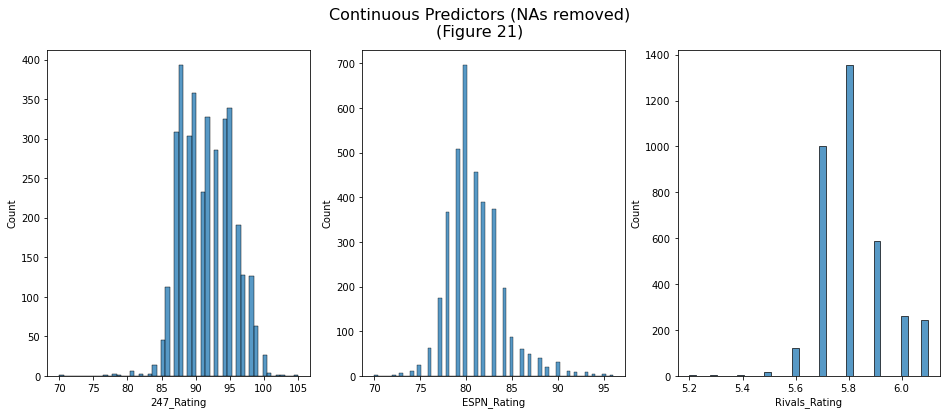

In [64]:
# HISTOGRAM FOR CONTINUOUS PREDICTORS
figure, ax = plt.subplots(1,3, figsize=(16,6))
sns.histplot(mod_df['ESPN_Rating'], ax=ax[1])
sns.histplot(mod_df['Rivals_Rating'], ax=ax[2])
sns.histplot(mod_df['247_Rating'], ax=ax[0])
figure.suptitle('Continuous Predictors (NAs removed)\n(Figure 21)', fontsize=16)
plt.savefig("Images/modeling/Continuous_Predictors.png", facecolor='white', edgecolor='white')
plt.show()

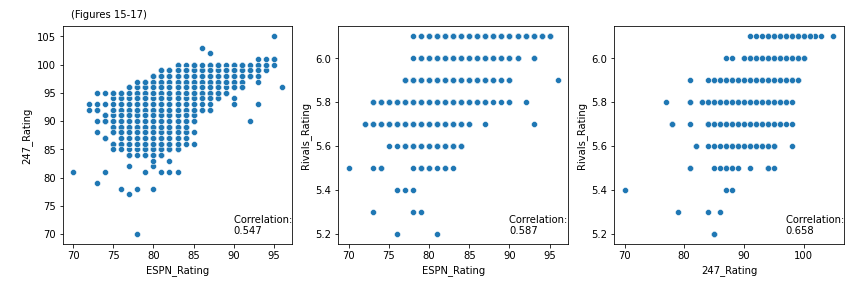

In [65]:
# SCATTERS FOR CONTINUOUS PREDICTORS
figure, ax = plt.subplots(1,3, figsize=(14,4))
p1 = sns.scatterplot(x=mod_df['ESPN_Rating'], y=mod_df['247_Rating'], ax=ax[0])
p1.annotate('Correlation: \n'+str(np.round(np.corrcoef(mod_df['ESPN_Rating'], mod_df['247_Rating'])[0][1],3)), 
           xy=(90, 70))
p2 = sns.scatterplot(x=mod_df['ESPN_Rating'], y=mod_df['Rivals_Rating'], ax=ax[1])
p2.annotate('Correlation: \n'+str(np.round(np.corrcoef(mod_df['ESPN_Rating'], mod_df['Rivals_Rating'])[0][1],3)), 
           xy=(90, 5.2))
p3 = sns.scatterplot(x=mod_df['247_Rating'], y=mod_df['Rivals_Rating'], ax=ax[2])
p3.annotate('Correlation: \n'+str(np.round(np.corrcoef(mod_df['247_Rating'], mod_df['Rivals_Rating'])[0][1],3)), 
           xy=(97, 5.2))
plt.annotate('(Figures 15-17)', xy=(.07, .92), xycoords='figure fraction')
plt.savefig('Images/modeling/correlated_Xs.png', facecolor='white')
plt.show()

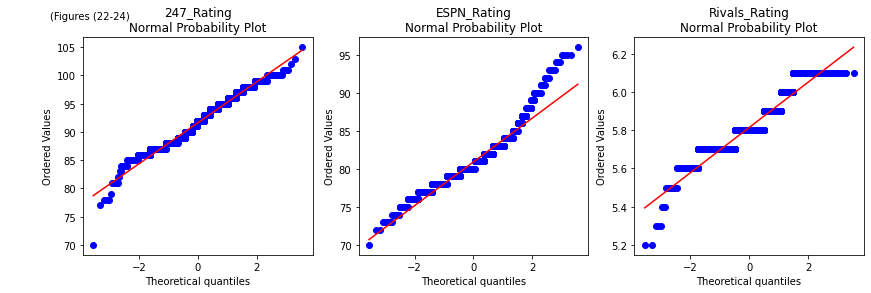

In [66]:
# NORMAL PROB PLOTS FOR CONTINUOUS PREDICTORS
figure, ax = plt.subplots(1,3, figsize=(14,4))
ax = 131
for i,v in enumerate(mod_df.columns[['Rating' in c for c in mod_df.columns]]):
    x = 'ax'+str(i)
    exec(f'{x} = plt.subplot(ax)')
    cht = stats.probplot(mod_df[v].dropna(), dist='norm', plot=plt)
    plt.title(v+'\nNormal Probability Plot')
    ax=ax+1
plt.annotate('(Figures (22-24)', xy=(.05,.95), xycoords='figure fraction')
plt.savefig('Images/modeling/Normal_ProbPlots.png', facecolor='white', edgecolor='white')
plt.show()

### Building models

In [68]:
# split data into drafted and undrafted subsets
drft = mod_df[mod_df['drafted']==1]
non_drft = mod_df[mod_df['drafted']==0]

In [69]:
# establish naive accuracy and class imbalance
naive_acc = len(non_drft)/len(mod_df) #imbalance %
naive_acc

0.779783393501805

In [70]:
# establish initial x & y for use in any unbalanced classifiers on all data
y = mod_df['drafted']
x = mod_df[mod_df.columns[[('Rating' in c)|('Star' in c) for c in mod_df.columns]]]

# scale the x values so larger magnitude ratings are not favored
x_scaled = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)

# train test split the data
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y, test_size=.2, random_state=0, stratify=mod_df['drafted'])

#### visualization model ####
commented code below used for visual only (figures 26-28)

i changed values by hand here, so running commented code would only show 1 of the 3 charts

In [1946]:
# y = mod_df['drafted']
# x = pd.DataFrame(mod_df['Rivals_Rating'])

# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=0, stratify=mod_df['drafted'])

# LR = LogisticRegressionCV(cv=3).fit(x_train, y_train)

# rang = [i/10 for i in range(int(x.min().values[0]*10), 62, 1)]
# probs = [LR.predict_proba([[i]])[0][1] for i in rang]
# acc = str(np.round(metrics.accuracy_score(y_test, LR.predict(x_test)), 3))
# auc = str(np.round(metrics.roc_auc_score(y_test, LR.predict(x_test)), 3))
# plt.plot(rang, probs, label='Logistic Regression \n Accuracy='+acc+' auc='+auc)
# plt.title('Predicted probability to be drafted')

# plt.axvline(x=6.1, ymin=0, ymax=.94, color='red')
# pr_5 = str(np.round(LR.predict_proba([[6.1]])[0][1]*100, 2))
# plt.annotate("5star cut-off\n"+pr_5+"%", xy=(5.9,.47))
# plt.axvline(x=5.8, ymin=0, ymax=.38, color='red')
# pr_4 = str(np.round(LR.predict_proba([[5.8]])[0][1]*100, 2))
# plt.annotate("4star cut-off\n"+pr_4+"%", xy=(5.63,.19))
# plt.axvline(x=5.5, ymin=0, ymax=.12, color='red')
# pr_3 = str(np.round(LR.predict_proba([[5.5]])[0][1]*100, 2))
# plt.annotate("3star cut-off\n"+pr_3+"%", xy=(5.4,.06))
# plt.legend(loc=0)
# plt.xlabel('Rivals_Rating')
# plt.ylabel('Probability')
# plt.annotate('(Figure 28)', xy=(.1,.91), xycoords='figure fraction')
# plt.savefig('Images/modeling/Rivals_rating_predict.png', facecolor='white')

### INITIAL MODEL classification on ALL data

In [2120]:
LR = LogisticRegressionCV(cv=3).fit(x_train, y_train) # initial logistic regression model

In [2051]:
RF = ensemble.RandomForestClassifier(max_depth=5).fit(x_train, y_train) # initial random forest

In [2052]:
tr = DecisionTreeClassifier(max_depth=2).fit(x_train, y_train) # initial tree model

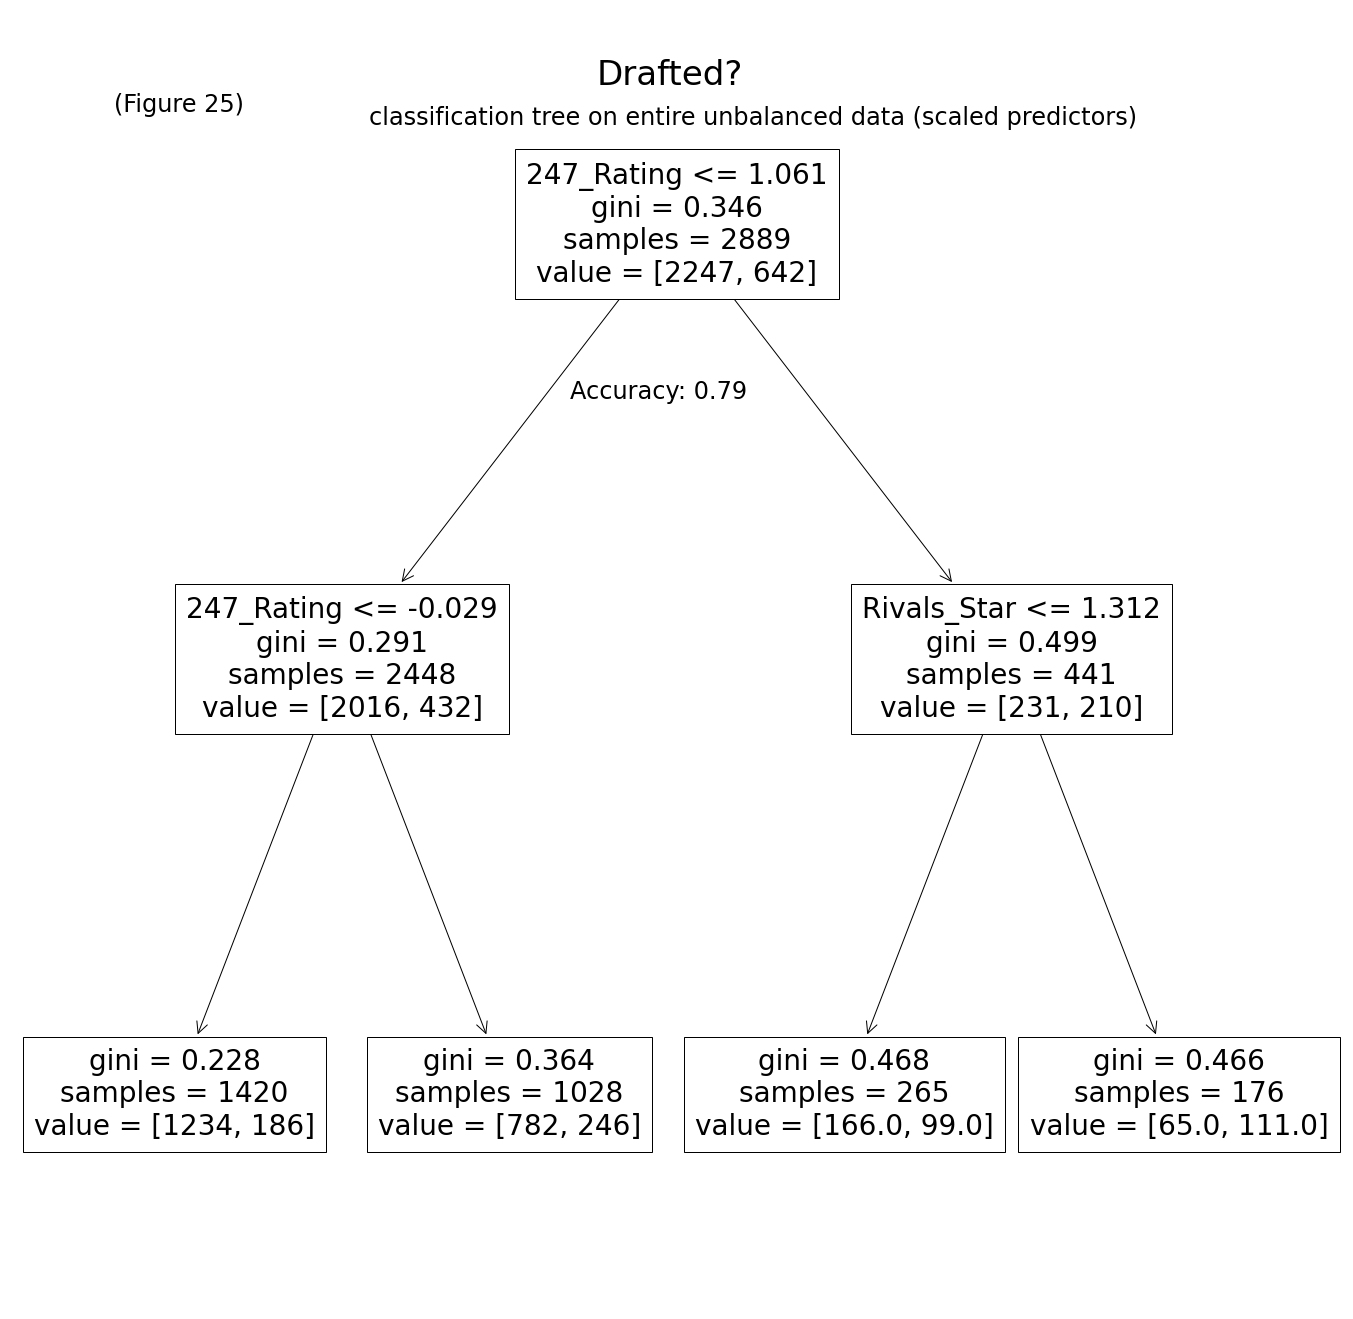

In [1945]:
# PLOT INITIAL TREE ON ALL DATA
plt.figure(figsize=(24,24))
plot_tree(tr, feature_names=tr.feature_names_in_)
plt.annotate('Drafted?', xy=(.44,.94), fontsize=34)
plt.annotate('\nclassification tree on entire unbalanced data (scaled predictors)', xy=(.27,.91), fontsize=24)
plt.annotate('(Figure 25)', xy=(.08,.92), fontsize=24)
plt.annotate('Accuracy: '+str(np.round(metrics.accuracy_score(y_test, tr.predict(x_test)),3)), 
             xy=(.42, .7), fontsize=24)
plt.savefig('Images/modeling/classification_tree_alldata.png', facecolor='white')
plt.show()

**Use PCA to visualize dependent variable space then color with drafted class**
    
    - and plot with just 2 continuous x-vars

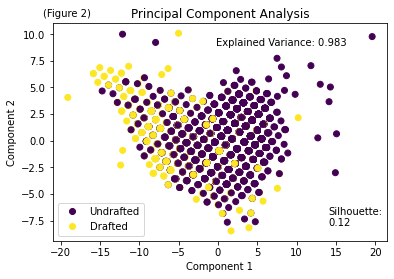

In [72]:
# compress all dependent variables into 2D for plot
mod = PCA(n_components=2)
pca = mod.fit_transform(mod_df[mod_df.columns[:-1]]) 
expl = str(np.round(mod.explained_variance_ratio_.sum(),3))
silh = np.round(metrics.silhouette_score(mod_df[mod_df.columns[:-1]], mod_df['drafted']), 3)
scat = plt.scatter(pca[:, 0], pca[:, 1], c=mod_df['drafted'].values)
plt.legend(handles=scat.legend_elements()[0], labels=['Undrafted', 'Drafted'])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.annotate('Silhouette:\n'+str(silh), xy=(14,-8))
plt.annotate('(Figure 2)', xy=(.1,.91), xycoords='figure fraction')
plt.annotate('Explained Variance: '+expl, xy=(.5,.81), xycoords='figure fraction')
plt.title('Principal Component Analysis')
plt.savefig('Images/PCA_scatter.png', facecolor='white')
plt.show()

In [2661]:
from sklearn.datasets import make_blobs

In [2744]:
dat = make_blobs(n_samples=2000, centers=2, cluster_std=.8, random_state=3) # generate fake cluster data

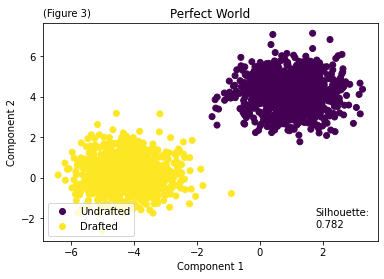

In [2746]:
# PERFECT WORLD PCA PLOT
points = dat[0]
# plot blob cluster data (fake data)
plt.scatter(points[:,0], points[:,1], c=dat[1])
silh = np.round(metrics.silhouette_score(points, dat[1]), 3)
plt.legend(handles=scat.legend_elements()[0], labels=['Undrafted', 'Drafted'], loc=3)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.annotate('Silhouette:\n'+str(silh), xy=(.73,.18), xycoords='figure fraction')
plt.annotate('(Figure 3)', xy=(.1,.91), xycoords='figure fraction')
plt.title('Perfect World')
plt.savefig('Images/IDEAL_scatter.png', facecolor='white')
plt.show()

**Plot ROC curves for initial models on all data**

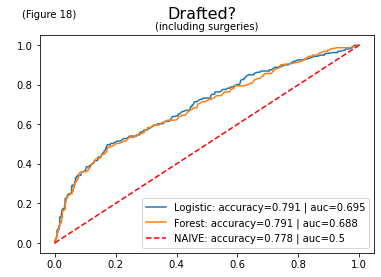

In [2053]:
# PLOT ROC CURVES FOR ALL INITIAL MODELS ON UNBALANCED DATA
probs = LR.predict_proba(x_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, probs)
auc = np.round(metrics.roc_auc_score(y_test, probs),3)
acc = np.round(metrics.accuracy_score(y_test, LR.predict(x_test)), 3)
nacc = np.round(naive_acc, 3)
nauc = np.round(metrics.roc_auc_score(y_test, np.repeat(0, len(y_test))), 3)

probs1 = RF.predict_proba(x_test)[:,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test, probs1)
auc1 = np.round(metrics.roc_auc_score(y_test, probs1),3)
acc1 = np.round(metrics.accuracy_score(y_test, RF.predict(x_test)), 3)

# PLOT ROC LINES
plt.plot(fpr,tpr,label="Logistic: accuracy="+ str(acc) +" | auc="+str(auc))
plt.annotate(text="(Figure 18)", xy=(.05, .9), xycoords='figure fraction')
plt.suptitle('Drafted?', fontsize=16)
plt.title('(including surgeries)', fontsize=10)
plt.plot(fpr1, tpr1, label='Forest: accuracy='+str(acc1)+" | auc="+str(auc1))
plt.plot([0, 1], [0, 1],'r--', label="NAIVE: accuracy="+str(nacc)+" | auc="+str(nauc))
plt.legend(loc=0)
# plt.savefig('Images/modeling/Classif_onAll+surg.png', facecolor='white', edgecolor='white')
plt.show()

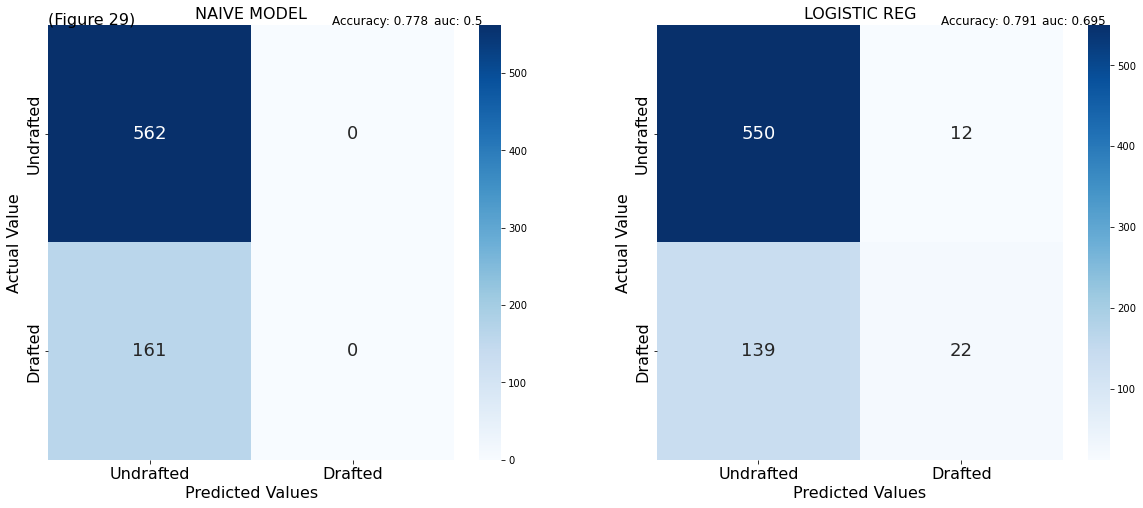

In [2121]:
# CONFUSION MATRIX FOR INITIAL LOGISTIC REG ON ALL DATA
size = 16
figure, ax = plt.subplots(1,2, figsize=(20,8))
heat = sns.heatmap(metrics.confusion_matrix(y_test, np.repeat(0, len(y_test))), fmt='g', annot=True, cmap='Blues', 
                   ax=ax[0], annot_kws={"size": 18})
heat.set_title("NAIVE MODEL", fontsize=size)
heat.set_xlabel("Predicted Values", fontsize=size)
heat.set_ylabel("Actual Value", fontsize=size)
heat.xaxis.set_ticklabels(['Undrafted', 'Drafted'], fontsize=size)
heat.yaxis.set_ticklabels(['Undrafted', 'Drafted'], fontsize=size)
heat.annotate('Accuracy: '+str(np.round(naive_acc,3)), xy=(1.4,0), fontsize=12)
heat.annotate('auc: 0.5', xy=(1.9,0), fontsize=12)
heat.annotate('(Figure 29)', xy=(0,0), fontsize=size)

# logistic reg on all unbalanced data conf matrix
probs = LR.predict_proba(x_test)[:,1]
ht = sns.heatmap(metrics.confusion_matrix(y_test, LR.predict(x_test)), fmt='g', annot=True, cmap='Blues', ax=ax[1], 
                annot_kws={"size": 18})
ht.set_title("LOGISTIC REG", fontsize=size)
ht.set_xlabel("Predicted Values", fontsize=size)
ht.set_ylabel("Actual Value", fontsize=size)
ht.xaxis.set_ticklabels(['Undrafted', 'Drafted'], fontsize=size)
ht.yaxis.set_ticklabels(['Undrafted', 'Drafted'], fontsize=size)
ht.annotate('Accuracy: '+str(np.round(metrics.accuracy_score(y_test, LR.predict(x_test)),3)), xy=(1.4,0), fontsize=12)
ht.annotate('auc: '+str(np.round(metrics.roc_auc_score(y_test, probs),3)), xy=(1.9,0), fontsize=12)
plt.savefig('Images/modeling/confusion_matrices.png', facecolor='white')
plt.show()


### MODEL PART 2: model on BALANCED subsets

In [106]:
# randomly sample undrafted subset
mod_subs = pd.concat([drft, non_drft.sample(n=len(drft))])
y = mod_subs['drafted']
x = mod_subs[mod_subs.columns[[('Rating' in c)|('Star' in c) for c in mod_subs.columns]]]

# scale the x values so larger magnitude ratings are not favored
x_scaled = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)

# train test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y, test_size=.2, random_state=0, stratify=mod_subs['drafted'])

In [107]:
# LOGISTIC REG ON BALANCED SUB
LR = LogisticRegressionCV(cv=3, fit_intercept=False, scoring='roc_auc').fit(x_train, y_train)

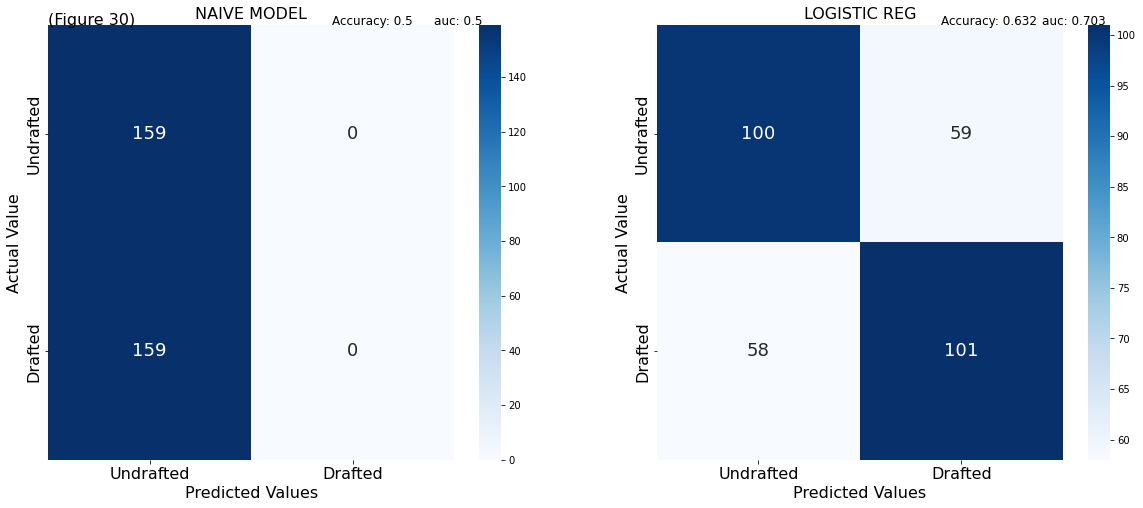

In [108]:
# CONFUSION MATRIX NAIVE VS LOGISTIC REG ON BALANCED SUB
size = 16
figure, ax = plt.subplots(1,2, figsize=(20,8))
heat = sns.heatmap(metrics.confusion_matrix(y_test, np.repeat(0, len(y_test))), fmt='g', annot=True, cmap='Blues', 
                   ax=ax[0], annot_kws={"size": 18})
heat.set_title("NAIVE MODEL", fontsize=size)
heat.set_xlabel("Predicted Values", fontsize=size)
heat.set_ylabel("Actual Value", fontsize=size)
heat.xaxis.set_ticklabels(['Undrafted', 'Drafted'], fontsize=size)
heat.yaxis.set_ticklabels(['Undrafted', 'Drafted'], fontsize=size)
heat.annotate('Accuracy: '+str(0.5), xy=(1.4,0), fontsize=12)
heat.annotate('auc: 0.5', xy=(1.9,0), fontsize=12)
heat.annotate('(Figure 30)', xy=(0,0), fontsize=size)

# logistic reg on balanced subset conf matrix
probs = LR.predict_proba(x_test)[:,1]
ht = sns.heatmap(metrics.confusion_matrix(y_test, LR.predict(x_test)), fmt='g', annot=True, cmap='Blues', ax=ax[1], 
                annot_kws={"size": 18})
ht.set_title("LOGISTIC REG", fontsize=size)
ht.set_xlabel("Predicted Values", fontsize=size)
ht.set_ylabel("Actual Value", fontsize=size)
ht.xaxis.set_ticklabels(['Undrafted', 'Drafted'], fontsize=size)
ht.yaxis.set_ticklabels(['Undrafted', 'Drafted'], fontsize=size)
ht.annotate('Accuracy: '+str(np.round(metrics.accuracy_score(y_test, LR.predict(x_test)),3)), xy=(1.4,0), fontsize=12)
ht.annotate('auc: '+str(np.round(metrics.roc_auc_score(y_test, probs),3)), xy=(1.9,0), fontsize=12)
plt.savefig('Images/modeling/confusion_matrices_subset.png', facecolor='white')
plt.show()


In [109]:
# Balanced logistic reg model predicted probabilites, fpr,tpr, etc for ROC chart later
probsLR = LR.predict_proba(x_test)[:,1]
fprLR, tprLR, _ = metrics.roc_curve(y_test, probsLR)
aucLR = np.round(metrics.roc_auc_score(y_test, probsLR),3)
accLR = np.round(metrics.accuracy_score(y_test, LR.predict(x_test)), 3)
nacc_sub = np.round(np.sum(y_test==0)/len(y_test), 3) # naive accuracy
nauc_sub = np.round(metrics.roc_auc_score(y_test, np.repeat(0, len(y_test))), 3)

In [110]:
# randomly sample undrafted subset
mod_subs = pd.concat([drft, non_drft.sample(n=len(drft))])
y = mod_subs['drafted']
x = mod_subs[mod_subs.columns[[('Rating' in c)|('Star' in c) for c in mod_subs.columns]]]

# scale the x values so larger magnitude ratings are not favored
x_scaled = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)

# train test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y, test_size=.2, random_state=0, stratify=mod_subs['drafted'])

In [111]:
# TREE MODEL ON RANDOM BALANCED SUBSET
trees = ensemble.RandomForestClassifier(max_depth=5, n_estimators=250).fit(x_train, y_train)

In [112]:
# Balanced tree model predicted probabilites, fpr,tpr, etc for ROC chart later
probsTR = trees.predict_proba(x_test)[:,1]
fprTR, tprTR, _ = metrics.roc_curve(y_test, probsTR)
aucTR = np.round(metrics.roc_auc_score(y_test, probsTR),3)
accTR = np.round(metrics.accuracy_score(y_test, trees.predict(x_test)), 3)

In [113]:
# randomly sample undrafted subset
mod_subs = pd.concat([drft, non_drft.sample(n=len(drft))])
y = mod_subs['drafted']
x = mod_subs[mod_subs.columns[[('Rating' in c)|('Star' in c) for c in mod_subs.columns]]]

# scale the x values so larger magnitude ratings are not favored
x_scaled = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)

# train test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y, test_size=.2, random_state=0, stratify=mod_subs['drafted'])

In [114]:
# SUPPORT VECTOR MACHINE ON BALANCED SUBSET
modsvm = svm.SVC(kernel='rbf', probability=True).fit(x_train, y_train)

In [115]:
# Balanced SVM model predicted probabilites, fpr,tpr, etc for ROC chart later
probsSVM = modsvm.predict_proba(x_test)[:,1]
fprSVM, tprSVM, _ = metrics.roc_curve(y_test, probsSVM)
aucSVM = np.round(metrics.roc_auc_score(y_test, probsSVM),3)
accSVM = np.round(metrics.accuracy_score(y_test, modsvm.predict(x_test)), 3)

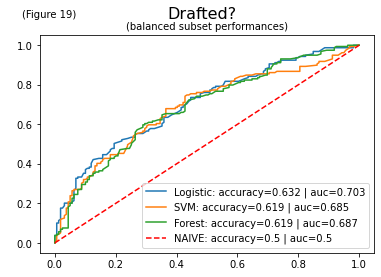

In [116]:
# PLOT ALL BALANCED SUBSET MODELS PERFORMANCES 
plt.plot(fprLR,tprLR,label="Logistic: accuracy="+ str(accLR) +" | auc="+str(aucLR))
plt.annotate(text="(Figure 19)", xy=(.05, .9), xycoords='figure fraction')
plt.suptitle('Drafted?', fontsize=16)
plt.title('(balanced subset performances)', fontsize=10)
plt.plot(fprSVM, tprSVM, label='SVM: accuracy='+str(accSVM)+" | auc="+str(aucSVM))
plt.plot(fprTR, tprTR, label='Forest: accuracy='+str(accTR)+" | auc="+str(aucTR))
plt.plot([0, 1], [0, 1],'r--', label="NAIVE: accuracy="+str(nacc_sub)+" | auc="+str(nauc_sub))
plt.legend(loc=0)
plt.savefig('Images/modeling/Classif_onSubs.png', facecolor='white', edgecolor='white')
plt.show()

**STACK them H***!!**
    
    - stack the balanced subset models into a meta learner

In [117]:
# META LEARNER WILL USE ALL DATA, NOT A BALANCED SUBSET, bc we want it to be realistic
y = mod_df['drafted']
x = mod_df[mod_df.columns[[('Rating' in c)|('Star' in c) for c in mod_df.columns]]]

# scale the x values so larger magnitude ratings are not favored
x_scaled = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)

x_train, x_test, y_train, y_test = train_test_split(x_scaled,y, test_size=.2, random_state=0, stratify=mod_df['drafted'])

# stack all trained models
stak = ensemble.StackingClassifier(estimators=[('SVM', modsvm), ('LR', LR), ('tree', trees)],
                          final_estimator=LogisticRegression()).fit(x_train, y_train)

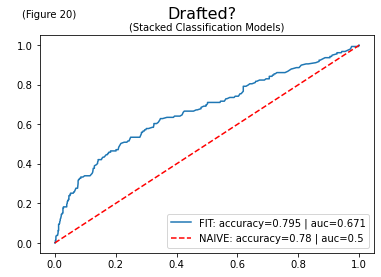

In [118]:
# ROC CURVE PLOT FOR STACKED META LEARNER
probs = stak.predict_proba(x_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, probs)
auc = np.round(metrics.roc_auc_score(y_test, probs),3)
acc = np.round(metrics.accuracy_score(y_test, stak.predict(x_test)), 3)
nacc = np.round(naive_acc, 3)
nauc = np.round(metrics.roc_auc_score(y_test, np.repeat(0, len(y_test))), 3)

# plt.figure(figsize=(8,8))
plt.plot(fpr,tpr,label="FIT: accuracy="+ str(acc) +" | auc="+str(auc))
plt.annotate(text="(Figure 20)", xy=(.05, .9), xycoords='figure fraction')
plt.suptitle('Drafted?', fontsize=16)
plt.title('(Stacked Classification Models)', fontsize=10)
plt.plot([0, 1], [0, 1],'r--', label="NAIVE: accuracy="+str(nacc)+" | auc="+str(nauc))
plt.legend(loc=4)
plt.savefig('Images/modeling/Stacked_Classification_ROC.png', facecolor='white', edgecolor='white')
plt.show()


**Probability that model is only as accurate/auc as naive given cross val scores**

In [119]:
# AUC scores from 15 rounds of cross validation
# aucs = cross_val_score(stak, x_train, y_train, scoring='roc_auc', cv=15)

In [120]:
# accuracy scores from 15 rounds of cross validation
accs = cross_val_score(stak, x_train, y_train, scoring='accuracy', cv=15)

In [125]:
print("Probability the model is at best 5% more accurate than guessing:\n", np.round(stats.norm.cdf(x=naive_acc+.05, loc=accs.mean(), scale=accs.std())*100, 2))

Probability the model is at best 5% more accurate than guessing:
 99.73


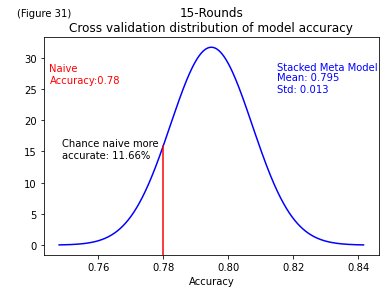

In [129]:
# ESTIMATED NORMAL DIST OF STACKED META LEARNER TRUE ACCURACY vs NAIVE ACCURACY
rand_x = stats.norm.ppf(q=[i/10000 for i in range(1,10000, 1)], loc=accs.mean(), scale=accs.std())
plt.plot(rand_x, stats.norm.pdf(x=rand_x, loc=accs.mean(), scale=accs.std()), color='blue')
plt.axvline(x=naive_acc, ymin=0, ymax=.5, color='red')
p_val = str(np.round(stats.norm.cdf(x=naive_acc, loc=accs.mean(), scale=accs.std())*100, 2))
plt.annotate('Chance naive more\naccurate: '+p_val+"%", xy=(.749, 14))
plt.title('15-Rounds\nCross validation distribution of model accuracy')
plt.annotate('Stacked Meta Model', xy=(.815, 28), color='blue')
plt.annotate('Mean: '+str(np.round(accs.mean(),3))+'\nStd: '+str(np.round(accs.std(),3)), xy=(.815, 24.5), color='blue')
plt.annotate('(Figure 31)', xy=(.04, .96), xycoords='figure fraction')
plt.annotate('Naive\nAccuracy:'+str(np.round(naive_acc,3)), xy=(.745, 26), color='red')
plt.xlabel('Accuracy')
plt.savefig('Images/modeling/staked_popdistribution.png', facecolor='white')
plt.show()

# theres a [left tail p-value] chance that our model is less accurate than the naive in reality